In [3]:
import pandas as pd
import numpy as np
import json
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis,moma,add_moma
import pickle
from tqdm import tqdm 
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import sys
sys.path.append('../retrosynthesis/')

from common import *

# from IgnoreMet import *



### input and output

In [1]:
### input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/yeast8U_del2_re.yml'
# new_met_info_to_GEM_path = '../Data/metabolites_info_to_GEM_yeast8_top50.csv'
target_product_file_path = '../../Data/100met.xlsx'
metabolites_info_to_GEM_path = '../../Results/not_lipid/top50_0.3_re/metabolites_info_to_GEM_top50_0.3.csv'
miss_id_path = '../../Data/model/miss_met_id.json'
### output
source_fig4b_path = '../../Results/source_data/fig4-b.csv'
yeast8U_native_product_reaction_figure_path = '../../Results/Figures/fig4-b.pdf'

### ① Product degradation

In [3]:
def get_yeast8_metid_for_keggid(model,keggid):
    metid = 'no this met'
    for met in model.metabolites:
        if met.compartment == 'c':
            if 'kegg.compound' in model.metabolites.get_by_id(met.id).annotation:
                if model.metabolites.get_by_id(met.id).annotation['kegg.compound'] == keggid:
                    metid = met.id
    return(metid)

In [ ]:
def calculate_FBA(Target_met,model):
    exchange_reaction = get_exchange_reaction(Target_met,model)
    model.objective = model.reactions.get_by_id(exchange_reaction)
    model.optimize()
    ### Remove the added reaction
    if abs(model.reactions.get_by_id(exchange_reaction).flux)>0.001:
        flux_tmp = model.reactions.get_by_id(exchange_reaction).flux
    else:
        flux_tmp = 0
    if 'DM_' in exchange_reaction:
        model.remove_reactions(exchange_reaction)    
    return flux_tmp

In [5]:
def top_three_elements(lst):
    counter = Counter(lst)
    top_three = counter.most_common(3)
    top_three_elements = [item[0] for item in top_three]
    return top_three_elements

def get_subsystem(Target_met,model):
    exchange_reaction = get_exchange_reaction(Target_met,model)
    model.objective = model.reactions.get_by_id(exchange_reaction)
    model.optimize()
    subsystem_list = []
    for i in model.reactions:
        if abs(i.flux)>0.001:
            try:
                subsystem_list.append(i.subsystem[0])
            except: pass

    if 'DM_' in exchange_reaction:
        model.remove_reactions(exchange_reaction)   
    # return subsystem_list
    subsystem_list = [x for x in subsystem_list if 'Transport' not in x and 'Exchange' not in x]
    return top_three_elements(subsystem_list)

In [6]:
def prepare_target_product(target_product_file_path,yeast870_path):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    target_product_pd = pd.read_excel(target_product_file_path)
    target_product_pd.dropna(inplace=True)
    target_product_pd = target_product_pd[target_product_pd['Group'] == 'native']
    target_product_pd['yeast8_id'] = target_product_pd['KEGG ID'].apply(lambda x: get_yeast8_metid_for_keggid(yeast8,x))
    target_product_pd['FBA'] = target_product_pd['yeast8_id'].apply(lambda x : calculate_FBA(x,yeast8))
    target_product_pd = target_product_pd[target_product_pd['FBA']>0.0001]
    target_product_pd['subsystem'] = target_product_pd['yeast8_id'].apply(lambda x : get_subsystem(x,yeast8))
    print(target_product_pd.shape)
    return target_product_pd

In [7]:
target_product_pd = prepare_target_product(target_product_file_path,yeast870_path)

/home/haohao/anaconda3/envs/gurob/lib/python3.8/site-packages/cobra/core/model.py:777: UserWarning: need to pass in a list
  warn("need to pass in a list")
/home/haohao/anaconda3/envs/gurob/lib/python3.8/site-packages/cobra/core/model.py:777: UserWarning: need to pass in a list
  warn("need to pass in a list")


(52, 10)


In [8]:
target_product_pd

,Name,Formula,KEGG ID,CHEBI ID,Group,class,Gene target,yeast8_id,FBA,subsystem
0,"(R,R)-2,3-butanediol",C4H10O2,C03044,16982,native,alcohol,Link,s_0035,1.077151,"[Glycolysis / gluconeogenesis, Glycine, serine..."
1,2-phenylethanol,C8H10O,C05853,49000,native,alcohol,Link,s_0185,0.544096,"[Glycolysis / gluconeogenesis, Citrate cycle (..."
2,glycerol,C3H8O3,C00116,17754,native,alcohol,Link,s_0765,1.558928,"[Glycolysis / gluconeogenesis, Citrate cycle (..."
3,isoamylol,C5H12O,C07328,15837,native,alcohol,Link,s_0929,0.728744,"[Valine, leucine and isoleucine metabolism, Gl..."
4,isobutanol,C4H10O,C14710,46645,native,alcohol,Link,s_0932,1.000000,"[Glycolysis / gluconeogenesis, Thiamine metabo..."
5,choline,C5H14NO,C00114,15354,native,alkaloid,Link,s_0512,0.548334,"[Glycolysis / gluconeogenesis, Pentose phospha..."
6,hypoxanthine,C5H4N4O,C00262,17368,native,alkaloid,Link,s_0843,0.909592,"[Purine metabolism, Citrate cycle (TCA cycle),..."
7,xanthine,C5H4N4O2,C00385,17712,native,alkaloid,Link,s_0357,0.877896,"[Purine metabolism, Glycolysis / gluconeogenes..."
8,glutathione,C10H17N3O6S,C00051,16856,native,amino acid,Link,s_0750,0.451167,"[Glycolysis / gluconeogenesis, Pentose phospha..."
9,L-alanine,C3H7NO2,C00041,16977,native,amino acid,Link,s_0955,1.815018,"[Glycolysis / gluconeogenesis, Pentose phospha..."


In [9]:
yeast8U = cobra.io.load_yaml_model(yeast8U_path)

In [10]:
with open(miss_id_path) as f:
    miss_met_id = json.load(f)


In [11]:
yeast8 = cobra.io.load_yaml_model(yeast870_path)
met_info = pd.read_csv(metabolites_info_to_GEM_path)

def get_smiles(metid,model,met_info):
    # print(metid)
    smiles = None
    if metid.startswith('s_'):
        if hasattr(model.metabolites.get_by_id(metid), 'smiles'):
            smiles = model.metabolites.get_by_id(metid).smiles
    elif metid.startswith('sn_'):
        if metid in met_info['ID'].tolist():
            smiles =  met_info[met_info['ID'] == metid]['new_met_smiles'].to_list()[0]
    return smiles

In [12]:
def get_new_smiles_lst_has_carbon(self_smiles,smiles_lst):
    smiles_lst = list(set(smiles_lst))
    smiles_lst = [x for x in smiles_lst if not compare_smiles_inchikey(self_smiles,x)]
    smiles_lst = [x for x in smiles_lst if calculate_carbon_count(x)<=calculate_carbon_count(self_smiles)]
    result = []
    for i in smiles_lst:
        if any(compare_smiles_inchikey(i,j) for j in result):
            pass
        else:
            result.append(i)
    return result

In [13]:
target_met = 's_0680'#s_1025#s_0991
def target_met_in_reaction_lst(target_met,yeast8U):
    reaction_lst = []
    for rea in yeast8U.reactions:
        if target_met in rea.reaction and rea.bounds==(0,1000) and  rea.metabolites[yeast8U.metabolites.get_by_id(target_met)]<0:
            reaction_lst.append(rea.id)
        elif target_met in rea.reaction and rea.bounds==(-1000,0) and  rea.metabolites[yeast8U.metabolites.get_by_id(target_met)]>0:
            reaction_lst.append(rea.id)
        elif target_met in rea.reaction and rea.bounds==(-1000,1000):
            reaction_lst.append(rea.id)
    return reaction_lst
target_met_in_reaction_lst(target_met,yeast8U)

['r_0159',
 'r_0163',
 'r_1762',
 'r_1763',
 'r_4711',
 'r_4712',
 'r_4713',
 'r_4714',
 'r_4715',
 'r_4716',
 'r_4720',
 'r_4721',
 'rxn14765',
 'rxn44336',
 'rxn25879',
 'rxn54403',
 'rxn64957',
 'rxn64958',
 'rxn71687',
 'rxn75929',
 'rxn11677',
 'rxn11678',
 'rxn11688',
 'rxn11689',
 'rxn12309',
 'rxn5824']

In [14]:
target_product_pd['yeast8_reaction_lst'] = target_product_pd['yeast8_id'].apply(lambda x: target_met_in_reaction_lst(x,yeast8))
target_product_pd['yeast8U_reaction_lst'] = target_product_pd['yeast8_id'].apply(lambda x: target_met_in_reaction_lst(x,yeast8U))

target_product_pd['yeast8_reaction_num'] = target_product_pd['yeast8_reaction_lst'].apply(lambda x:len(x))
target_product_pd['yeast8U_reaction_num'] = target_product_pd['yeast8U_reaction_lst'].apply(lambda x: len(x))

In [15]:
target_100met_df = target_product_pd[['Name','Group','class','yeast8_reaction_lst','yeast8_reaction_num','yeast8U_reaction_lst','yeast8U_reaction_num']]
target_100met_df.head(3)

,Name,Group,class,yeast8_reaction_lst,yeast8_reaction_num,yeast8U_reaction_lst,yeast8U_reaction_num
0,"(R,R)-2,3-butanediol",native,alcohol,"[r_0003, r_1097]",2,"[r_0003, r_1097]",2
1,2-phenylethanol,native,alcohol,"[r_0162, r_1590, r_1591]",3,"[r_0162, r_1590, r_1591, rxn20557, rxn25236, r...",8
2,glycerol,native,alcohol,"[r_0487, r_0488, r_1172, r_3597]",4,"[r_0487, r_0488, r_1172, r_3597, rxn37611, rxn...",35


In [16]:
target_100met_df['class'].value_counts()

class
amino acid                24
organic acid               9
alcohol                    5
fatty acids and lipids     4
alkaloid                   3
other                      3
bioamine                   2
nucleic acid               2
Name: count, dtype: int64

In [17]:
classes_order = ['nucleic acid', 'bioamine','other','alkaloid','fatty acids and lipids','alcohol','organic acid','amino acid']
target_100met_df = target_100met_df.sort_values(by='class', key=lambda x: pd.Categorical(x, categories=classes_order, ordered=True), na_position='last')
target_100met_df = target_100met_df.groupby('class', sort=False).apply(lambda x: x.sort_values(by='yeast8U_reaction_num', ascending=True)).reset_index(drop=True)
target_100met_df.head(3)

,Name,Group,class,yeast8_reaction_lst,yeast8_reaction_num,yeast8U_reaction_lst,yeast8U_reaction_num
0,thymidine,native,nucleic acid,"[r_2074, r_2075]",2,"[r_2074, r_2075, rxn27399, rxn27400, rxn6871, ...",6
1,guanine,native,nucleic acid,"[r_0526, r_0527, r_0949, r_1176, r_1819, r_4758]",6,"[r_0526, r_0527, r_0949, r_1176, r_1819, r_475...",26
2,spermine,native,bioamine,"[r_0937, r_1262, r_1263, r_1739]",4,"[r_0937, r_1262, r_1263, r_1739]",4


In [18]:
target_100met_df.head(1)

,Name,Group,class,yeast8_reaction_lst,yeast8_reaction_num,yeast8U_reaction_lst,yeast8U_reaction_num
0,thymidine,native,nucleic acid,"[r_2074, r_2075]",2,"[r_2074, r_2075, rxn27399, rxn27400, rxn6871, ...",6


In [19]:
target_100met_df = target_100met_df[target_100met_df['class']!='fatty acids and lipids'].reset_index(drop=True)
target_100met_df

,Name,Group,class,yeast8_reaction_lst,yeast8_reaction_num,yeast8U_reaction_lst,yeast8U_reaction_num
0,thymidine,native,nucleic acid,"[r_2074, r_2075]",2,"[r_2074, r_2075, rxn27399, rxn27400, rxn6871, ...",6
1,guanine,native,nucleic acid,"[r_0526, r_0527, r_0949, r_1176, r_1819, r_4758]",6,"[r_0526, r_0527, r_0949, r_1176, r_1819, r_475...",26
2,spermine,native,bioamine,"[r_0937, r_1262, r_1263, r_1739]",4,"[r_0937, r_1262, r_1263, r_1739]",4
3,putrescine,native,bioamine,"[r_1001, r_1251, r_1252]",3,"[r_1001, r_1251, r_1252, rxn26973, rxn41825, r...",18
4,urea,native,other,"[r_0189, r_1075, r_1273, r_4210]",4,"[r_0189, r_1075, r_1273, r_4210, rxn3657]",5
5,ergosterol,native,other,"[r_1068, r_1147, r_1148, r_1758, r_1759, r_355...",7,"[r_1068, r_1147, r_1148, r_1758, r_1759, r_355...",8
6,acetaldehyde,native,other,"[r_0095, r_0173, r_0960, r_1632, r_1633, r_211...",8,"[r_0095, r_0173, r_0960, r_1632, r_1633, r_211...",25
7,xanthine,native,alkaloid,"[r_1091, r_2101]",2,"[r_1091, r_2101, rxn37957, rxn34169, rxn3246, ...",10
8,choline,native,alkaloid,"[r_0273, r_1684, r_4332]",3,"[r_0273, r_1684, r_4332, rxn20125, rxn20126, r...",19
9,hypoxanthine,native,alkaloid,"[r_0562, r_0951, r_1842]",3,"[r_0562, r_0951, r_1842, rxn37849, rxn37884, r...",19


In [20]:
target_100met_df.to_csv(source_fig4b_path,index=None)

# figure

/tmp/ipykernel_2516076/2942232006.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


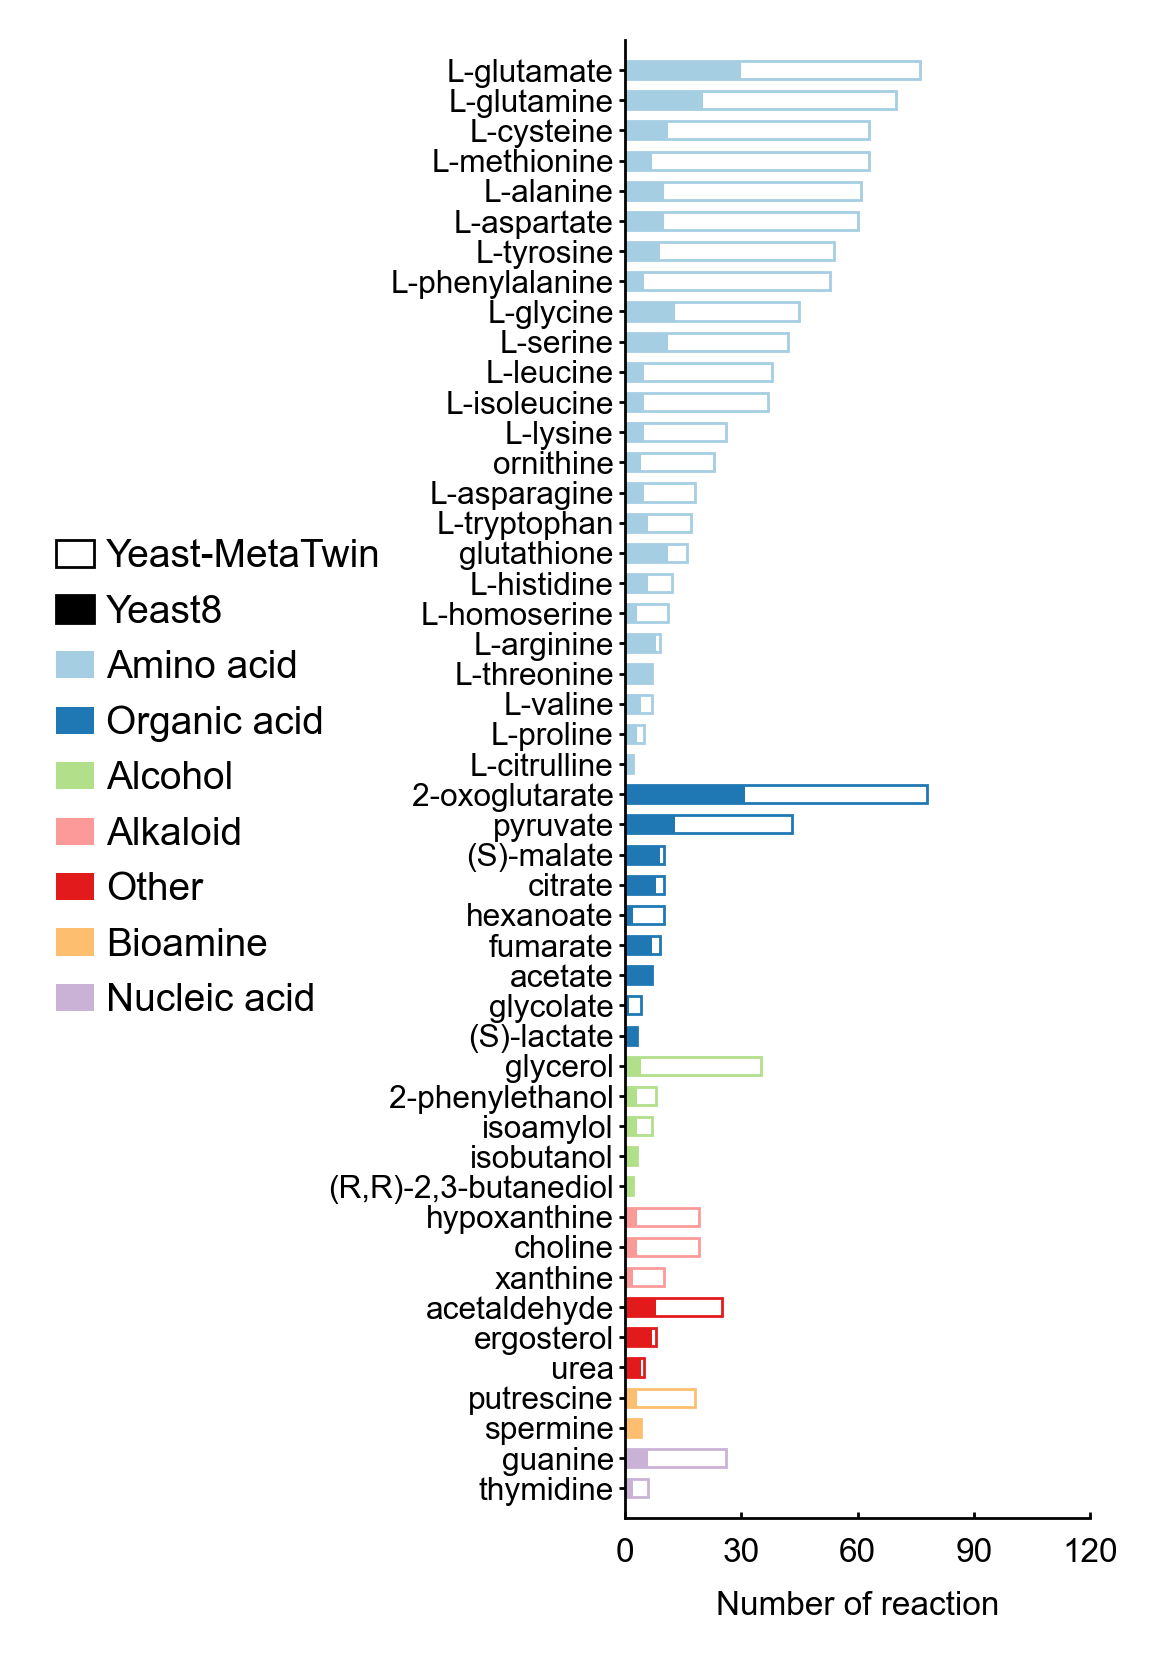

In [21]:
# Set common parameters
plt.figure(figsize=(1.5, 4.8), dpi=400)
plt.rcParams.update({'font.size': 6})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Set axis style
ax = plt.gca()
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0)

# Draw stacked bar chart, swapping x and y axes
bar_width = 0.6
index = np.arange(len(target_100met_df['Name']))

# Define colors and sections
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#fb9a99', '#e31a1c', '#fdbf6f', '#cab2d6']
sections = [(24, 48), (15, 24), (10, 15), (7, 10), (4, 7), (2, 4), (0, 2)]
labels = ['Amino acid', 'Organic acid', 'Alcohol', 'Alkaloid', 'Other', 'Bioamine', 'Nucleic acid']

for i, (start, end) in enumerate(sections):
    plt.barh(index[start:end], target_100met_df['yeast8U_reaction_num'][start:end], height=bar_width, color='white', edgecolor=colors[i], linewidth=0.5)
    plt.barh(index[start:end], target_100met_df['yeast8_reaction_num'][start:end], height=bar_width, label=labels[i], color=colors[i])

# Set axis parameters
plt.tick_params(axis='x', direction='in', width=0.5, which='both', length=1)
plt.tick_params(axis='y', which='both', width=0.5, length=1, pad=1)
plt.ylim(-1, 48)
plt.xlim(0, 120)
plt.yticks(index, target_100met_df['Name'], fontsize=5.7)
plt.xticks(np.arange(0, 121, 30), fontsize=6)
plt.xlabel('Number of reaction', fontsize=6)

# Set legend
custom_patch1 = mpatches.Patch(facecolor='white', edgecolor='black', linewidth=0.5, label='Yeast-MetaTwin')
custom_patch2 = mpatches.Patch(facecolor='black', edgecolor='black', linewidth=0.5, label='Yeast8')

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Insert custom legend entries
handles.insert(0, custom_patch1)
handles.insert(1, custom_patch2)

# Create legend
plt.legend(handles=handles, frameon=False, fontsize=7, loc='center left', bbox_to_anchor=(-1.3, 0.5), labelspacing=0.5, handletextpad=0.3, handlelength=1)

plt.tight_layout()
plt.savefig(yeast8U_native_product_reaction_figure_path, dpi=400, bbox_inches='tight')
plt.show()

## ec

In [22]:
target_100met_df.head(1)

,Name,Group,class,yeast8_reaction_lst,yeast8_reaction_num,yeast8U_reaction_lst,yeast8U_reaction_num
0,thymidine,native,nucleic acid,"[r_2074, r_2075]",2,"[r_2074, r_2075, rxn27399, rxn27400, rxn6871, ...",6


In [23]:
def get_gene_lst_for_reaction_lst(reaction_lst,yeast8U):
    gene_lst = []
    for i in reaction_lst:
        # print(yeast8U.reactions.get_by_id(i).gpr)
        gene_tmp_lst = str(yeast8U.reactions.get_by_id(i).gpr).replace('(','').replace(')','').replace(' and ',' ').replace(' or ',' ').split(' ')
        # print(gene_tmp_lst)
        gene_lst += gene_tmp_lst
    gene_lst = list(set(gene_lst))
    gene_lst = [x for x in gene_lst if x!='']
    return gene_lst

reaction_lst = ['r_0526']
get_gene_lst_for_reaction_lst(reaction_lst,yeast8U)

['YDL238C']

In [24]:
target_100met_df['yeast8_gene'] = target_100met_df['yeast8_reaction_lst'].apply(lambda x:get_gene_lst_for_reaction_lst(x,yeast8))
target_100met_df['yeast8U_gene'] = target_100met_df['yeast8U_reaction_lst'].apply(lambda x:get_gene_lst_for_reaction_lst(x,yeast8U))

target_100met_df['yeast8_gene_num'] = target_100met_df['yeast8_gene'].apply(lambda x:len(x))
target_100met_df['yeast8U_gene_num'] = target_100met_df['yeast8U_gene'].apply(lambda x:len(x))

In [25]:
target_100met_df['class'].value_counts()

class
amino acid      24
organic acid     9
alcohol          5
other            3
alkaloid         3
nucleic acid     2
bioamine         2
Name: count, dtype: int64

In [26]:
target_100met_df_1 = target_100met_df[target_100met_df['class']=='amino acid']
target_100met_df_2 = target_100met_df[target_100met_df['class']=='organic acid']
target_100met_df_3 = target_100met_df[target_100met_df['class']=='alcohol']
# target_100met_df_4 = target_100met_df[target_100met_df['class']=='fatty acids and lipids']
target_100met_df_5 = target_100met_df[target_100met_df['class']=='other']
target_100met_df_6 = target_100met_df[target_100met_df['class']=='alkaloid']
target_100met_df_7 = target_100met_df[target_100met_df['class']=='nucleic acid']
target_100met_df_8 = target_100met_df[target_100met_df['class']=='bioamine']

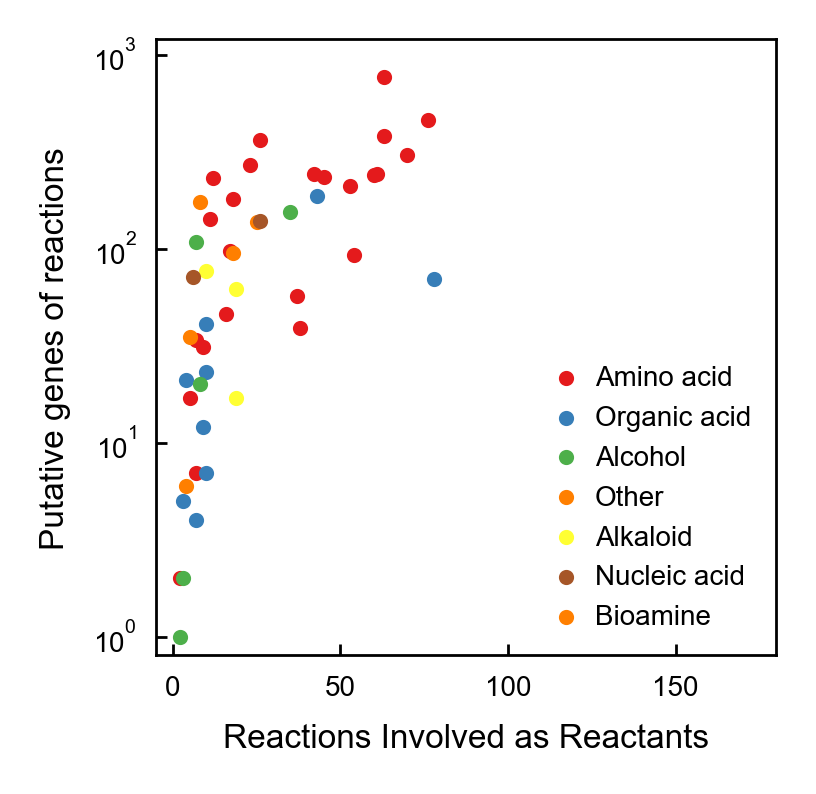

In [27]:
# Setting General Parameters
plt.figure(figsize=(2, 2), dpi=400)
plt.rcParams.update({'font.size': 6})
plt.rcParams['font.family'] = 'Arial'

# Setting Axis Styles
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)

# Plot scatter points with normalized 'score'
plt.scatter(target_100met_df_1['yeast8U_reaction_num'], target_100met_df_1['yeast8U_gene_num'], s=3, c='#e41a1c', label='Amino acid')
plt.scatter(target_100met_df_2['yeast8U_reaction_num'], target_100met_df_2['yeast8U_gene_num'], s=3, c='#377eb8', label='Organic acid')
plt.scatter(target_100met_df_3['yeast8U_reaction_num'], target_100met_df_3['yeast8U_gene_num'], s=3, c='#4daf4a', label='Alcohol')
plt.scatter(target_100met_df_5['yeast8U_reaction_num'], target_100met_df_5['yeast8U_gene_num'], s=3, c='#ff7f00', label='Other')
plt.scatter(target_100met_df_6['yeast8U_reaction_num'], target_100met_df_6['yeast8U_gene_num'], s=3, c='#ffff33', label='Alkaloid')
plt.scatter(target_100met_df_7['yeast8U_reaction_num'], target_100met_df_7['yeast8U_gene_num'], s=3, c='#a65628', label='Nucleic acid')
plt.scatter(target_100met_df_8['yeast8U_reaction_num'], target_100met_df_8['yeast8U_gene_num'], s=3, c='#ff7f00', label='Bioamine')

# Setting X-axis and Y-axis Labels
plt.xlabel('Reactions Involved as Reactants', fontsize=6)
plt.ylabel('Putative genes of reactions', fontsize=6)

# Configure x and y axis limits and scales
plt.xlim(-5, 180)
plt.ylim(0.8, 1200)
plt.yscale('log')
plt.minorticks_off()  # Hide minor ticks

plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)

# Add legend
plt.legend(fontsize=5, markerscale=1, bbox_to_anchor=(1, 0), loc='lower right', frameon=False, handletextpad=0.05)

# Display the plot
plt.show()